# COMPUTE INFORMATION-THEORETIC METRICS

This python script computes four information-theoretic metrics on given EEG neural timeseries data, specifically for hyperscanning (part of a pipeline, HyPyP):
- Shannon Entropy (Univariate and Bivariate)
- Mutual Information
- Transfer Entropy
- Granger Emergence

Each of these will be explained in turn, with respective mathematical equations. For full derivations, see Appendix.

# Import Libraries

## Core

In [1]:
import io
from pathlib import Path
from copy import copy
from collections import OrderedDict

## Data Science

In [2]:
import numpy as np
import scipy
from scipy.integrate import odeint

## Visualisation

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera

## MNE

In [4]:
import mne

## HyPyP

In [5]:
from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz

# Load Data

Sample EEG data in fiff format: 
- /data/participant1-epo.fif
- /data/participant2-epo.fif

Can be found online: "https://github.com/ppsp-team/HyPyP/blob/master/data/.."

In [6]:
epo1 = mne.read_epochs(
    Path('data/participant1-epo.fif').resolve(),
    preload=True,
)

epo2 = mne.read_epochs(
    Path('data/participant2-epo.fif').resolve(),
    preload=True,
)

Reading /Users/edoardochidichimo/Desktop/HyPyP/data/participant1-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/edoardochidichimo/Desktop/HyPyP/data/participant2-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated


Ensure that there are the same number of epochs between the participants' data.

In [7]:
mne.epochs.equalize_epoch_counts([epo1, epo2])

Dropped 224 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 130, 131, 134, 135, 136, 137, 138, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

# DEFINE FUNCTION: compute_it_metrics()

This function will take 3 arguments: epo1 (mne.Epoch), epo2 (mne.Epoch), and mode (str).
Hereafter, epo1 and epo2 will be represented as X and Y, respectively.

When mode ==
- "Entropy": returns [$H(X), H(Y), H(X,Y)$]
- "MI": returns $I(X;Y)$
- "TE": returns [$TE_{X \rightarrow Y}, TE_{Y \rightarrow X}$]
- "GE": returns __

The function will take the shape
```python
def compute_it_metrics(epo1: mne.Epoch, epo2: mne.Epoch, mode: str)
```

First, we must extract the data from each epoch and store the tensor of raw data as variables ```a,b```. (Notice that these will take 3 dimensions: an array of channels, an array of epochs, an array of amplitude values (µV) with each value representing one timepoint.)

Although currently default, we set ```copy=False``` as FutureWarning indicates that this function will set to change default. Since we are not changing the data, we do not need to make a copy.

In [8]:
a = epo1.get_data(copy=False)
b = epo2.get_data(copy=False)

We can also decide which channel or epoch we want to work with, so let us set local variables. Later, we might choose to repeat our analyses across all epochs (trial-averaged). There are 36 channels and 31 epochs per participant in total, so be sure to use the range 0–35 when indexing. 

For demonstration purposes, let us take the first epoch of the first channel for both participants. In this way, variables ```X,Y``` become an array of 501 µV values. (This suggests that there are 501ms timestamps (= 5 seconds).)

In [9]:
n_ch = 0 #36 total
n_epo = 0 #31 total

X = a[n_ch][n_epo][:]
Y = b[n_ch][n_epo][:]

n_timepoints = len(X) # == len(Y) [remember: epo1, epo2 were equalised]

Let's visualise what these EEG signals look like...

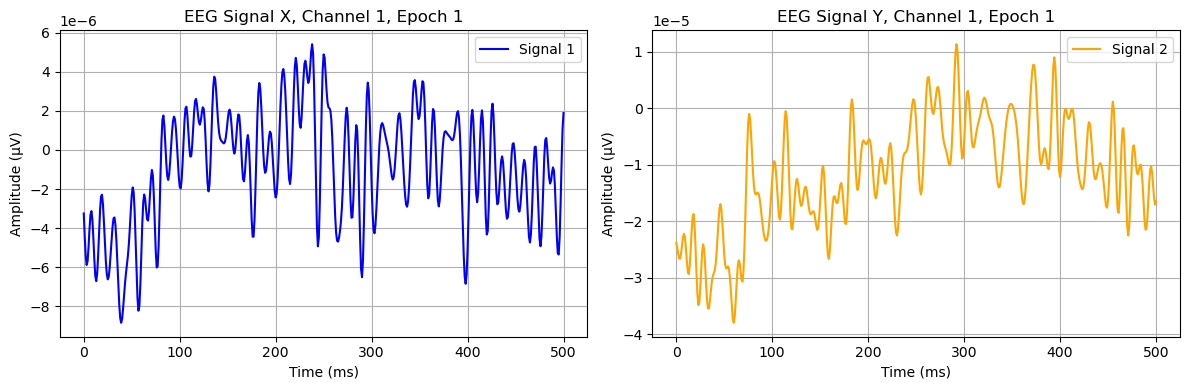

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(X, label='Signal 1', color='blue')
plt.title(f'EEG Signal X, Channel {n_ch+1}, Epoch {n_epo+1}')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(Y, label='Signal 2', color='orange')
plt.title(f'EEG Signal Y, Channel {n_ch+1}, Epoch {n_epo+1}')    
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Entropy

Recall that the Shannon information content of a sample ```x``` (whose value is a probability) is given by the equation

$\begin{equation}
h(x) = -log_2(x)
\end{equation}$

where $x$ is an outcome of random variable $X$ with probability distribution $p_X(x)$. In this context, if we wanted to find the information content of a sample where $x = P(X = 2$μV$)$, one would first count all the times in the signal 2μV appeared ($f$) and divide it by the total timepoints ($|\Omega|$ or ```n_timepoints```):

$x = P(X = 2\text{μV}) = \frac{f}{|\Omega|}$

In [11]:
f = sum(1 for i in range(n_timepoints) if a[n_ch][n_epo][i] == 2e-6)
print(f)

0


Here, this seems to indicate that the EEG signal is never at 2μV, even though our initial graph clearly indicates that a voltage of 2μV was recorded multiple times. However, given we have a discrete, non-infinite dataset with a sampling rate on the ms scale and high-precision floating-point numbers, it is very unlikely that any value of μV will repeat. Indeed, let's look at the first 10 amplitude values:

In [12]:
print(a[0][0][0:10])

[-3.25229999e-06 -4.42781136e-06 -5.42218048e-06 -5.88558514e-06
 -5.68590048e-06 -4.95354369e-06 -4.02638222e-06 -3.31316374e-06
 -3.12900816e-06 -3.57706454e-06]


In these cases, we will always result in a tiny $f$ value. This becomes clearer if we are to find the probability for every value with 16-bit accuracy ($P(X = 2.3782083)$ or $P(X = -3.4009829)$ etc.). 

A more meaningful approach would be to group the amplitude values into equally-sized bins (e.g., -5 – -2μV; -2 – 1μV; 1 – 4μV) and calculate the frequency of amp values in each bin. In this way, the possible samples ($|\Omega|$) become much more defined and frequencies become more meaningful.

But isn't the choice of bin size an arbitrary one? Indeed, it can be and it can influence your resulting entropy values. Therefore, we use ...

## Freedman-Diaconis Rule for determining frequency-distribution bin size

$\begin{equation}
\text{nbins} = \left\lceil \frac{\text{max}(X)-\text{min}(X)}{2Q_X n^{-1/3}} \right\rceil
\end{equation}$ 

where max($X$) and min($X$) signify the maximum and minimum values of variable $X$, respectively, $Q_X$ represents the interquartile range of $X$, and $n$ is the total number of data points (```n_timepoints```). To save repetition, let's compute these frequency distribution bins for both signals $X$ and $Y$. (Note that we can find the range by using ```np.ptp()```.) 

Later, when we compute joint probabilities, we will need to have a standardised frequency distribution bin size for both signals. Therefore, we take the average of both now.

In [13]:
fd_bins_X = np.ceil(np.ptp(X) / (2.0 * (np.percentile(X, 75) - np.percentile(X, 25)) * len(X)**(-1/3)))
fd_bins_Y = np.ceil(np.ptp(Y) / (2.0 * (np.percentile(Y, 75) - np.percentile(Y, 25)) * len(Y)**(-1/3)))
fd_bins = int(np.ceil((fd_bins_X+fd_bins_Y)/2))
print(fd_bins)

15


## Frequency Distribution
Now let's calculate the frequency distribution (using our averaged bin number). 

First, let's count how many times an amp value (remember all 501 of them) falls into each bin. Both ```counts_X``` and ```counts_Y``` will be arrays of frequencies for each of their bins — their "frequency distribution".

(Note, when using ```np.histogram```, ```density = True``` calculates the probability *density* distribution , whilst ```density = False``` calculates the probability *mass* function. The former is only used for continuous data and the latter for discrete data.)

In [14]:
counts_X, _ = np.histogram(X, bins = fd_bins, density = False)
counts_Y, _ = np.histogram(Y, bins = fd_bins, density = False)
print("The number of amp values recorded in each bin range are...\nX:", counts_X, "\nY:", counts_Y)

The number of amp values recorded in each bin range are...
X: [ 7  2 18 18 31 36 48 56 56 66 63 53 23 17  7] 
Y: [ 7  8 19 21 23 42 53 65 73 60 43 52 21 10  4]


## Probability Mass Distributions
Normalise the frequencies to obtain an array of probabilities (a "probability distribution") that an amp value will land in that bin. Since we are working with discretised data, we call this the probability *mass* distribution, as opposed to *density* for continuous data.

$\begin{equation}
p_X(x) = {P(X=\text{bin range 1}), P(X=\text{bin range 2}), ..., P(X=\text{bin range fd_bins})}
\end{equation}$

(Notice that ```sum(counts_X) == n_timepoints == len(X)```)

In [15]:
p_X = counts_X / n_timepoints
p_Y = counts_Y / n_timepoints
print("X:", p_X, "\nY:", p_Y)

X: [0.01397206 0.00399202 0.03592814 0.03592814 0.06187625 0.07185629
 0.09580838 0.11177645 0.11177645 0.13173653 0.1257485  0.10578842
 0.04590818 0.03393214 0.01397206] 
Y: [0.01397206 0.01596806 0.03792415 0.04191617 0.04590818 0.08383234
 0.10578842 0.12974052 0.14570858 0.11976048 0.08582834 0.10379242
 0.04191617 0.01996008 0.00798403]


We can visualise their normalised frequency or probability distributions:

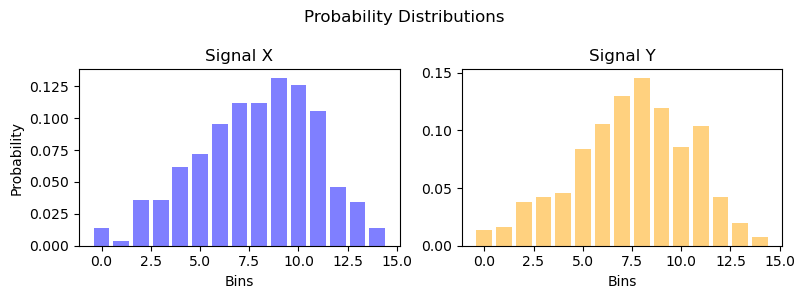

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    
axs[0].bar(np.arange(fd_bins), p_X, alpha=0.5, color='blue', label='Signal X')
axs[0].set_title('Signal X')
axs[0].set_xlabel('Bins')
axs[0].set_ylabel('Probability')

axs[1].bar(np.arange(fd_bins), p_Y, alpha=0.5, color='orange', label='Signal Y')
axs[1].set_title('Signal Y')
axs[1].set_xlabel('Bins')

plt.suptitle('Probability Distributions')
plt.tight_layout()
plt.show()

## Compute Shannon Entropy

Now that we have our probability distributions of both our signals, we can calculate the Shannon entropy for each signal.

Recall, that Shannon entropy is given by

\begin{equation}
H(X) = -\sum_{x \in X} P_X(x) \log_2(P_X(x))
\end{equation}

We are going to compute $H(X)$, $H(Y)$, and $H(X,Y)$, therefore we will instantiate a Shannon entropy array, ```S_entropy``` with three spaces.

In [17]:
S_entropy = np.zeros(3)
S_entropy[0] -= np.sum(p_X * np.log2(p_X + np.finfo(float).eps))
S_entropy[1] -= np.sum(p_Y * np.log2(p_Y + np.finfo(float).eps))

print("Shannon entropies: \nX:",S_entropy[0],"\nY:",S_entropy[1])

Shannon entropies: 
X: 3.5750004650908473 
Y: 3.556222587745282


## Joint Probability (Mass) Distributions
We can also plot all of our data from both signals onto one scatter plot and see the "marginal" probabilities of each on the side (note these are the same as the histograms above).

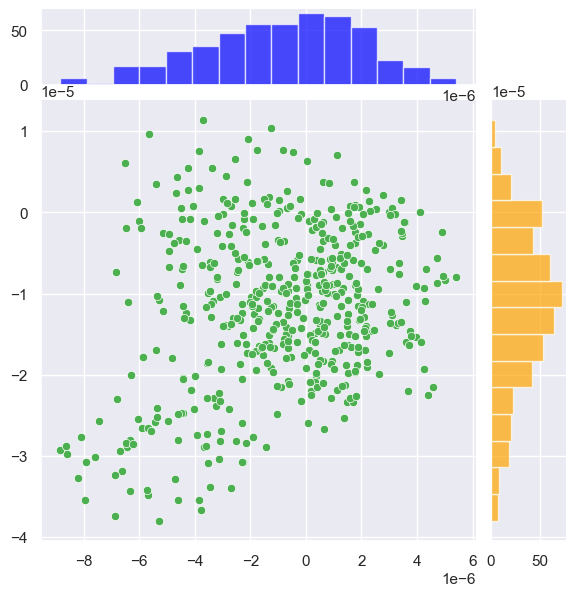

In [18]:
sns.set()
grid = sns.JointGrid(x=X, y=Y, marginal_ticks=True)
grid.plot_joint(sns.scatterplot, color='#4CAF50')
grid.ax_marg_x.hist(X, bins=fd_bins, color='blue', alpha=0.7)
grid.ax_marg_y.hist(Y, bins=fd_bins, color='orange', alpha=0.7, orientation='horizontal')

plt.xlabel('Signal X')
plt.ylabel('Signal Y')
plt.show()